In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from datetime import datetime
from sklearn.metrics import accuracy_score, recall_score, precision_score, matthews_corrcoef


In [133]:
train_df = pd.read_csv('risk-train.csv')
train_df.tail()
# train_df.info

,ORDER_ID,CLASS,B_EMAIL,B_TELEFON,B_BIRTHDATE,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_METHODE,Z_CARD_ART,Z_CARD_VALID,...,FAIL_RPLZ,FAIL_RORT,FAIL_RPLZORTMATCH,SESSION_TIME,NEUKUNDE,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,DATE_LORDER,MAHN_AKT,MAHN_HOECHST
29995,49821,no,yes,no,3/3/1981,yes,no,check,?,6.2005,...,no,no,no,10,no,1,40.83,3/9/2002,0,3
29996,49824,no,yes,no,2/21/1972,no,no,credit_card,Eurocard,5.2005,...,no,no,no,10,no,2,52.84,6/3/2001,0,0
29997,49825,no,yes,no,6/11/1980,no,no,credit_card,Eurocard,11.2006,...,no,no,no,6,yes,0,0.00,?,?,?
29998,49828,no,yes,no,12/4/1980,no,no,credit_card,Visa,4.2005,...,no,no,no,6,no,1,42.92,7/1/2001,0,0
29999,49829,no,yes,no,3/15/1958,no,no,credit_card,Eurocard,4.2006,...,no,no,no,11,no,1,27.29,1/30/2001,0,0


#### Lets indentify categorical and numerical variables, I will consider columns with 5 or less than 5 different values as categorical (exeption for WEEKDAY_ORDER that have 7 and is obviusly categorical)

In [134]:
print(train_df.nunique())
print('The length of data is',len(train_df))

ORDER_ID             30000
CLASS                    2
B_EMAIL                  2
B_TELEFON                2
B_BIRTHDATE          11143
FLAG_LRIDENTISCH         2
FLAG_NEWSLETTER          2
Z_METHODE                4
Z_CARD_ART               5
Z_CARD_VALID            36
Z_LAST_NAME              3
VALUE_ORDER           2341
WEEKDAY_ORDER            7
TIME_ORDER            1440
AMOUNT_ORDER             9
ANUMMER_01             560
ANUMMER_02             561
ANUMMER_03             561
ANUMMER_04             499
ANUMMER_05             348
ANUMMER_06             179
ANUMMER_07              90
ANUMMER_08              34
ANUMMER_09               8
ANUMMER_10               1
CHK_LADR                 2
CHK_RADR                 2
CHK_KTO                  2
CHK_CARD                 2
CHK_COOKIE               2
CHK_IP                   2
FAIL_LPLZ                2
FAIL_LORT                2
FAIL_LPLZORTMATCH        2
FAIL_RPLZ                2
FAIL_RORT                2
FAIL_RPLZORTMATCH        2
S

In [135]:
categorical_columns = ['B_EMAIL', 'B_TELEFON', 'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER', 'Z_METHODE', 'Z_CARD_ART', 'Z_LAST_NAME', 'WEEKDAY_ORDER', 'CHK_LADR', 'CHK_RADR', 'CHK_KTO', 'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ', 'FAIL_LORT', 'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT', 'FAIL_RPLZORTMATCH', 'NEUKUNDE', 'MAHN_AKT', 'MAHN_HOECHST']
numerical_columns = ['VALUE_ORDER', 'AMOUNT_ORDER', 'SESSION_TIME', 'AMOUNT_ORDER_PRE', 'VALUE_ORDER_PRE']

# For dates we have to do an extra analisys so I will separate them in a different category
date_columns = ['B_BIRTHDATE','Z_CARD_VALID', 'TIME_ORDER', 'DATE_LORDER']


In [136]:
# To check missing and zero values of a given column
def missing_values(column):
    missing_values = column.isna().sum() + (column == '?').sum()
    zero_values = (column == 0).sum()
    return missing_values, zero_values

In [137]:
def replace_zeros_with_mean(df, column_name, rounded=False):
    new_column = df[column_name].copy()
    non_zero_values = df.loc[df[column_name] != 0, column_name]
    if non_zero_values.empty:
        return new_column
    
    if rounded:
        non_zero_mean = int(round(non_zero_values.mean()))
    else:
        non_zero_mean = non_zero_values.mean()
    
    new_column = new_column.apply(lambda x: non_zero_mean if x == 0 else x)
    return new_column

### Numerical vars formatting and analisis

In [138]:
# Check empty spaces and zero values using the function already defined
for column in numerical_columns:
    print(column, missing_values(train_df[column]))

VALUE_ORDER (0, 0)
AMOUNT_ORDER (0, 0)
SESSION_TIME (0, 0)
AMOUNT_ORDER_PRE (0, 15856)
VALUE_ORDER_PRE (0, 15856)


#### We can see for the 3 first vars is not necesary to fill mising values but there are too many zero values in the last 2 ones

#### I dont want to remove these rows because represent more than half of the data so lets fill with mean (rounded value for AMOUNT_ORDER_PRE since cannot be a float)

In [139]:
# Numerical vars formatting
train_df['AMOUNT_ORDER_PRE'] = replace_zeros_with_mean(train_df, 'AMOUNT_ORDER_PRE', True)
train_df['VALUE_ORDER_PRE'] = replace_zeros_with_mean(train_df, 'VALUE_ORDER_PRE')
train_df.head()

,ORDER_ID,CLASS,B_EMAIL,B_TELEFON,B_BIRTHDATE,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_METHODE,Z_CARD_ART,Z_CARD_VALID,...,FAIL_RPLZ,FAIL_RORT,FAIL_RPLZORTMATCH,SESSION_TIME,NEUKUNDE,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,DATE_LORDER,MAHN_AKT,MAHN_HOECHST
0,49917,no,yes,no,1/17/1973,yes,yes,check,?,5.2006,...,no,no,no,8,yes,1,63.367475,?,?,?
1,49919,no,yes,yes,12/8/1970,no,no,credit_card,Visa,12.2007,...,yes,no,no,13,yes,1,63.367475,?,?,?
2,49923,no,yes,no,4/3/1972,yes,no,check,?,12.2007,...,no,no,no,3,yes,1,63.367475,?,?,?
3,49924,no,no,yes,8/1/1966,yes,no,check,?,1.2007,...,no,no,no,11,no,4,75.720000,5/12/2002,0,0
4,49927,no,yes,yes,12/21/1969,yes,no,credit_card,Eurocard,12.2006,...,no,no,no,16,yes,1,63.367475,?,?,?


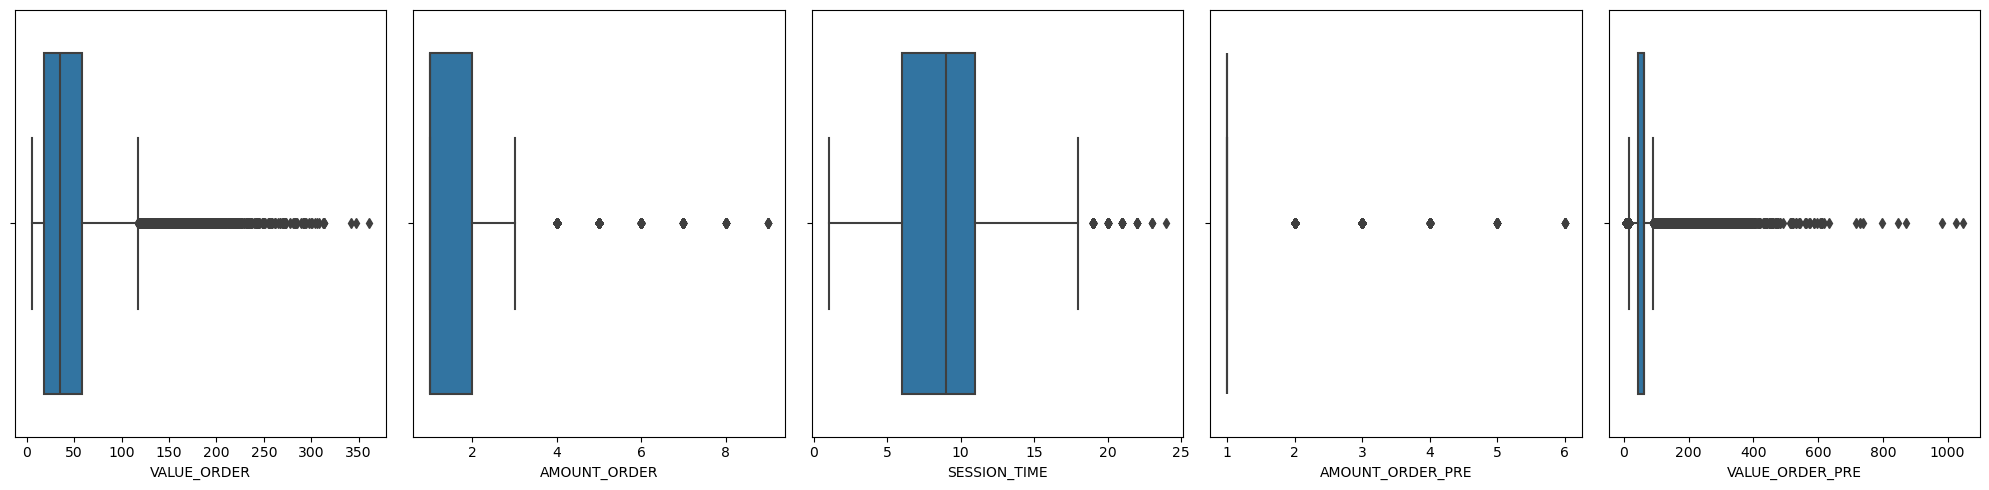

In [140]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for idx, col_name in enumerate(numerical_columns):
    sns.boxplot(x=train_df[col_name], ax=axes[idx])

plt.tight_layout()
plt.show()

#### Now lets handle the outliers

In [141]:
# Managing outliers
def adjust_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    min_val = Q1 - 1.5 * IQR
    max_val = Q3 + 1.5 * IQR
    
    df[column_name] = np.where(df[column_name] < min_val, min_val, df[column_name])
    df[column_name] = np.where(df[column_name] > max_val, max_val, df[column_name])
    return df[column_name]

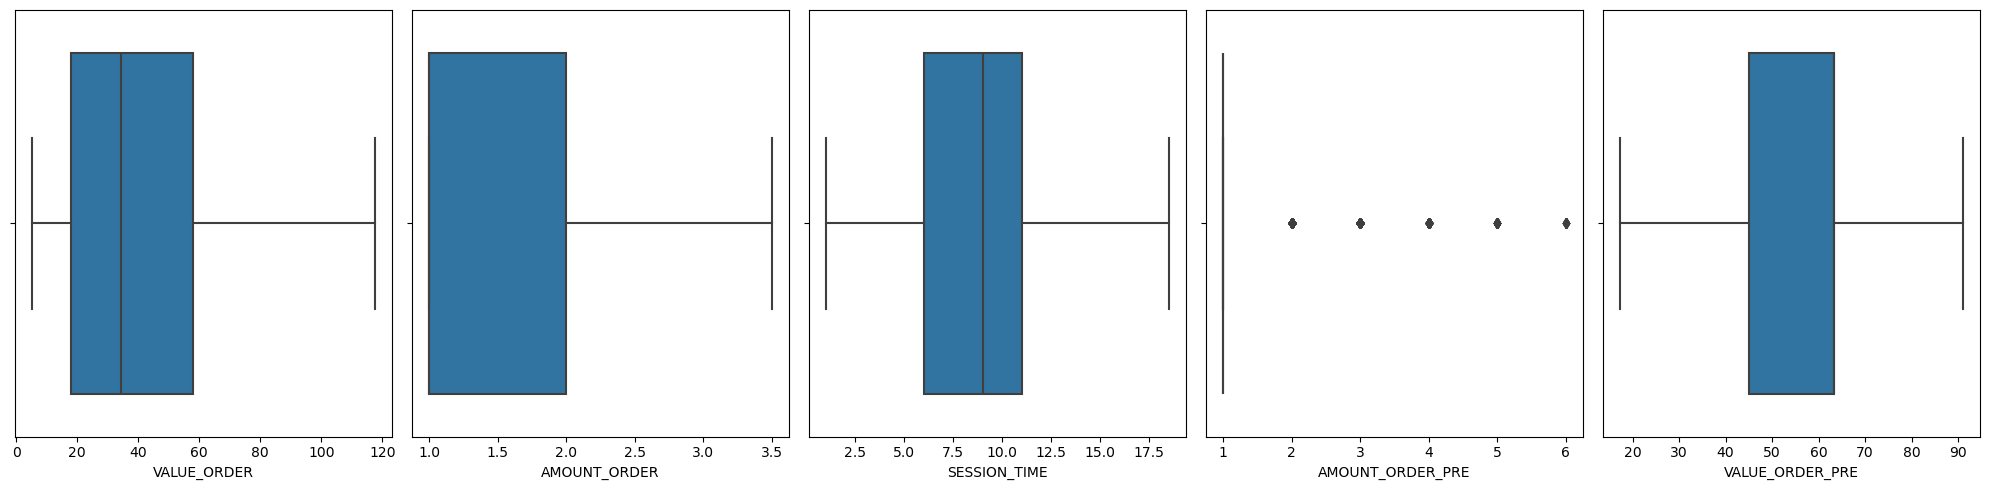

In [142]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for idx, col_name in enumerate(numerical_columns):
    if(col_name != 'AMOUNT_ORDER_PRE' ):
        train_df[col_name] = adjust_outliers(train_df, col_name)

    sns.boxplot(x=train_df[col_name], ax=axes[idx])

plt.tight_layout()
plt.show()

#### the outliers are cleaned so now Lets use T_test metric to select my predictors (this section is just for the numerical columns)

In [143]:
significant_predictors = []

for column_name in numerical_columns:
    group1 = train_df[train_df['CLASS'] == 'yes'][column_name]
    group2 = train_df[train_df['CLASS'] == 'no'][column_name]
    
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    if p_value < 0.05:
        significant_predictors.append(column_name)
        print(f"{column_name} is significant (p-value = {p_value})")
    else:
        print(f"{column_name} is NOT significant (p-value = {p_value})")

print("Significant predictors:", significant_predictors)

VALUE_ORDER is NOT significant (p-value = 0.09546065656803636)
AMOUNT_ORDER is significant (p-value = 0.005977777748190842)
SESSION_TIME is significant (p-value = 6.486405978689233e-23)
AMOUNT_ORDER_PRE is significant (p-value = 0.0002139414213478445)
VALUE_ORDER_PRE is significant (p-value = 1.3682560699032417e-10)
Significant predictors: ['AMOUNT_ORDER', 'SESSION_TIME', 'AMOUNT_ORDER_PRE', 'VALUE_ORDER_PRE']


In [144]:
#Feature Selection using T-statistic
df_1=train_df[train_df['CLASS']=='yes'][['VALUE_ORDER', 'AMOUNT_ORDER', 'SESSION_TIME', 'AMOUNT_ORDER_PRE', 'VALUE_ORDER_PRE']]
df_0=train_df[train_df['CLASS']=='no'][['VALUE_ORDER', 'AMOUNT_ORDER', 'SESSION_TIME', 'AMOUNT_ORDER_PRE', 'VALUE_ORDER_PRE']]
mean_1=np.mean(df_1,axis=0)
mean_0=np.mean(df_0,axis=0)
std_0=np.std(df_0,axis=0)/len(df_0)
std_1=np.std(df_1,axis=0)/len(df_1)
t_val=(mean_1-mean_0)/(std_0+std_1)**0.5


def get_pvalues(tt,n):
    p_val=stats.t.sf(abs(tt),n-1)*2
    return p_val
p_val=get_pvalues(t_val,len(df_1))
confidence=1-p_val

### Categorical vars formatting and analisis

In [145]:
# Check empty spaces
for column in categorical_columns:
    print(column, missing_values(train_df[column])[0])

B_EMAIL 0
B_TELEFON 0
FLAG_LRIDENTISCH 0
FLAG_NEWSLETTER 0
Z_METHODE 0
Z_CARD_ART 18654
Z_LAST_NAME 14808
WEEKDAY_ORDER 0
CHK_LADR 0
CHK_RADR 0
CHK_KTO 0
CHK_CARD 0
CHK_COOKIE 0
CHK_IP 0
FAIL_LPLZ 0
FAIL_LORT 0
FAIL_LPLZORTMATCH 0
FAIL_RPLZ 0
FAIL_RORT 0
FAIL_RPLZORTMATCH 0
NEUKUNDE 0
MAHN_AKT 15856
MAHN_HOECHST 15856


In [146]:
# Replace missing values of Z_CARD_ART with "no_card"
train_df.loc[:, 'Z_CARD_ART'] = train_df.loc[:, 'Z_CARD_ART'].replace('?', 'no_card')

# Replace missing values of Z_LAST_NAME  with "no"
train_df.loc[:, 'Z_LAST_NAME'] = train_df.loc[:, 'Z_LAST_NAME'].replace('?', 'no')

# Replace missing values of MAHN_AKT and MAHN_HOECHST with "zeros"
train_df.loc[:, 'MAHN_AKT'] = train_df.loc[:, 'MAHN_AKT'].replace('?', 0)
train_df.loc[:, 'MAHN_HOECHST'] = train_df.loc[:, 'MAHN_HOECHST'].replace('?', 0)

In [147]:
# categorical_vars = ['B_EMAIL', 'B_TELEFON', 'FLAG_LRIDENTISCH', 'FLAG_NEWSLETTER', 'Z_METHODE', 'Z_CARD_ART', 'Z_LAST_NAME', 'WEEKDAY_ORDER', 'CHK_LADR', 'CHK_RADR', 'CHK_KTO', 'CHK_CARD', 'CHK_COOKIE', 'CHK_IP', 'FAIL_LPLZ', 'FAIL_LORT', 'FAIL_LPLZORTMATCH', 'FAIL_RPLZ', 'FAIL_RORT', 'FAIL_RPLZORTMATCH', 'NEUKUNDE', 'MAHN_AKT', 'MAHN_HOECHST']
cat_significant_predictors = []

for col_name in categorical_columns:
    contingency_table = pd.crosstab(train_df[col_name], train_df['CLASS'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    # print(f'Chi-squared Test for {col_name}: p-value = {p}')
    if p < 0.05:
        cat_significant_predictors.append(col_name)
        print(f"{col_name} is significant (p-value = {p})")
    else:
        print(f"{col_name} is NOT significant (p-value = {p})")

print(cat_significant_predictors)

B_EMAIL is significant (p-value = 9.005843537131205e-50)
B_TELEFON is significant (p-value = 7.559208497150581e-17)
FLAG_LRIDENTISCH is NOT significant (p-value = 0.6201924633478395)
FLAG_NEWSLETTER is significant (p-value = 1.233239680602984e-06)
Z_METHODE is significant (p-value = 4.8959115945871013e-17)
Z_CARD_ART is significant (p-value = 5.879606186617081e-24)
Z_LAST_NAME is significant (p-value = 5.711107137892787e-11)
WEEKDAY_ORDER is significant (p-value = 2.912351285332683e-12)
CHK_LADR is significant (p-value = 5.063872541395484e-23)
CHK_RADR is significant (p-value = 1.1816503569307585e-07)
CHK_KTO is NOT significant (p-value = 0.12343412041573301)
CHK_CARD is NOT significant (p-value = 0.07716089683450886)
CHK_COOKIE is significant (p-value = 9.410485077501908e-14)
CHK_IP is significant (p-value = 1.85177489461951e-08)
FAIL_LPLZ is significant (p-value = 0.04926598058657373)
FAIL_LORT is significant (p-value = 6.741205726608488e-10)
FAIL_LPLZORTMATCH is NOT significant (p-v

In [148]:
date_cols = train_df[['B_BIRTHDATE','Z_CARD_VALID', 'TIME_ORDER', 'DATE_LORDER']]
# Check empty spaces
for column in date_cols:
    print(column, missing_values(train_df[column]))

B_BIRTHDATE (2942, 0)
Z_CARD_VALID (0, 0)
TIME_ORDER (20, 0)
DATE_LORDER (15856, 0)


In [149]:
def mean_date(df, col_name):
    non_empty_dates = df[col_name].loc[df[col_name] != '?']
    dates = pd.to_datetime(non_empty_dates, format='%m/%d/%Y')
    mean_timestamp = dates.dropna().astype(np.int64).mean()
    mean_date = pd.to_datetime(mean_timestamp)
    return mean_date

In [150]:
# Filling B_BIRTHDATE empty values with mean date
birthday_mean_date = mean_date(train_df.copy(), 'B_BIRTHDATE')
train_df.loc[:, 'B_BIRTHDATE'] = train_df.loc[:, 'B_BIRTHDATE'].replace('?', birthday_mean_date)
train_df['B_BIRTHDATE'] = pd.to_datetime(train_df['B_BIRTHDATE'], format='%m/%d/%Y')
train_df['B_BIRTHDATE_YEAR'] = train_df['B_BIRTHDATE'].dt.year
train_df['B_BIRTHDATE_MONTH'] = train_df['B_BIRTHDATE'].dt.year
train_df['B_BIRTHDATE_DAY'] = train_df['B_BIRTHDATE'].dt.year
train_df.drop(columns=['B_BIRTHDATE'], inplace=True)

In [151]:
# format Z_CARD_VALID
Z_CARD_ZVALID_FORMATTED = train_df['Z_CARD_VALID'].astype(str)
month_year = Z_CARD_ZVALID_FORMATTED.str.split('.', expand=True)
train_df['Z_CARD_VALID'] = pd.to_datetime(month_year[1] + '-' + month_year[0] + '-01')
train_df['Z_CARD_VALID_YEAR'] = train_df['Z_CARD_VALID'].dt.year
train_df['Z_CARD_VALID_MONTH'] = train_df['Z_CARD_VALID'].dt.year
train_df.drop(columns=['Z_CARD_VALID'], inplace=True)

In [152]:
def classify_time(time_str):
    if time_str == '?':
        return time_str
    time_obj = datetime.strptime(time_str, "%H:%M")
    hour = time_obj.hour
    if 5 <= hour < 8:
        return "early morning"
    elif 8 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "night"

In [153]:
# format TIME_ORDER to 4 categories and fill empty values with the mode
train_df['TIME_ORDER'] = train_df['TIME_ORDER'].map(classify_time)
mode = train_df['TIME_ORDER'] .mode()[0]
train_df.loc[:, 'TIME_ORDER'] = train_df.loc[:, 'TIME_ORDER'].replace('?', mode)

#### I will just clasify this column into is first purchase yes - no, if the value in the column DATE_LORDER is empty I would take this as the first purchase of the customer

In [154]:
train_df['IS_FIRST_ORDER'] = train_df['DATE_LORDER'].apply(lambda x: 'yes' if x == '?' else 'no')
train_df.drop(columns=['DATE_LORDER'], inplace=True)

In [155]:
date_significant_predictors = []

for column_name in ['B_BIRTHDATE_YEAR', 'B_BIRTHDATE_MONTH', 'B_BIRTHDATE_DAY', 'Z_CARD_VALID_YEAR', 'Z_CARD_VALID_MONTH']:
    group1 = train_df[train_df['CLASS'] == 'yes'][column_name]
    group2 = train_df[train_df['CLASS'] == 'no'][column_name]
    
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    if p_value < 0.05:
        date_significant_predictors.append(column_name)
        print(f"{column_name} is significant (p-value = {p_value})")
    else:
        print(f"{column_name} is NOT significant (p-value = {p_value})")

for col_name in ['TIME_ORDER', 'IS_FIRST_ORDER']:
    contingency_table = pd.crosstab(train_df[col_name], train_df['CLASS'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    # print(f'Chi-squared Test for {col_name}: p-value = {p}')
    if p < 0.05:
        date_significant_predictors.append(col_name)
        print(f"{col_name} is significant (p-value = {p})")
    else:
        print(f"{col_name} is NOT significant (p-value = {p})")

print("Significant predictors:", date_significant_predictors)

B_BIRTHDATE_YEAR is NOT significant (p-value = 0.1709527977841823)
B_BIRTHDATE_MONTH is NOT significant (p-value = 0.1709527977841823)
B_BIRTHDATE_DAY is NOT significant (p-value = 0.1709527977841823)
Z_CARD_VALID_YEAR is NOT significant (p-value = 0.5458536463894527)
Z_CARD_VALID_MONTH is NOT significant (p-value = 0.5458536463894527)
TIME_ORDER is NOT significant (p-value = 0.5305786332895732)
IS_FIRST_ORDER is significant (p-value = 3.548213054299758e-52)
Significant predictors: ['IS_FIRST_ORDER']


In [156]:
columns_to_convert = cat_significant_predictors + date_significant_predictors
x = train_df[columns_to_convert + significant_predictors]
x = pd.get_dummies(x, columns=columns_to_convert)
y = train_df['CLASS'].apply(lambda x: '1' if x == 'yes' else '0')

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=40)

In [158]:
reg = 0.01
model = LogisticRegression(C=1/reg, solver="liblinear").fit(x_train, y_train)
predictions = model.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.9416666666666667


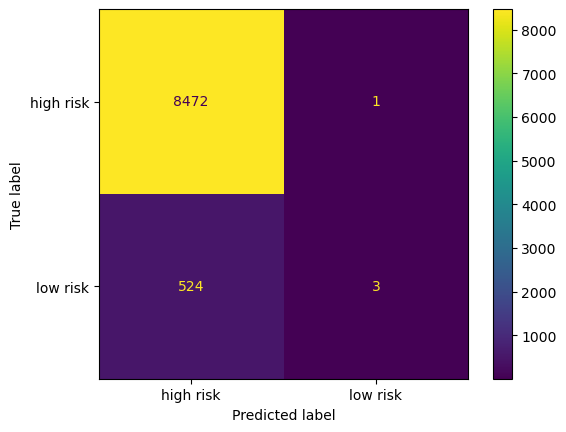

In [159]:
conf_matrix = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['high risk', 'low risk'])
cm_display.plot()

## Cleaning and formatting risk-test using the same procedure

In [160]:
test_df = pd.read_csv('risk-test.csv')
test_df.tail()
# test_df.info

,ORDER_ID,B_EMAIL,B_TELEFON,B_BIRTHDATE,FLAG_LRIDENTISCH,FLAG_NEWSLETTER,Z_METHODE,Z_CARD_ART,Z_CARD_VALID,Z_LAST_NAME,...,FAIL_RPLZ,FAIL_RORT,FAIL_RPLZORTMATCH,SESSION_TIME,NEUKUNDE,AMOUNT_ORDER_PRE,VALUE_ORDER_PRE,DATE_LORDER,MAHN_AKT,MAHN_HOECHST
19995,49820,yes,no,4/14/1965,yes,no,check,?,7.2005,?,...,no,no,no,17,no,1,80.99,2/10/2003,0,0
19996,49822,yes,no,8/8/1975,no,no,credit_card,Eurocard,3.2007,yes,...,no,no,no,9,yes,0,0.00,?,?,?
19997,49823,yes,no,5/11/1949,no,no,credit_card,Visa,10.2007,yes,...,no,no,no,9,yes,0,0.00,?,?,?
19998,49826,yes,no,4/14/1976,no,no,debit_card,debit_card,5.2005,yes,...,no,no,no,12,no,0,0.00,?,?,?
19999,49827,yes,no,10/21/1976,no,no,debit_note,?,12.2007,yes,...,no,no,no,10,no,1,104.93,12/3/2001,0,2


In [161]:
test_df['AMOUNT_ORDER_PRE'] = replace_zeros_with_mean(test_df, 'AMOUNT_ORDER_PRE', True)
test_df['VALUE_ORDER_PRE'] = replace_zeros_with_mean(test_df, 'VALUE_ORDER_PRE')

In [162]:
for idx, col_name in enumerate(numerical_columns):
    if(col_name != 'AMOUNT_ORDER_PRE' ):
        test_df[col_name] = adjust_outliers(test_df, col_name)

In [163]:
# Replace missing values of Z_CARD_ART with "no_card"
test_df.loc[:, 'Z_CARD_ART'] = test_df.loc[:, 'Z_CARD_ART'].replace('?', 'no_card')

# Replace missing values of Z_LAST_NAME  with "no"
test_df.loc[:, 'Z_LAST_NAME'] = test_df.loc[:, 'Z_LAST_NAME'].replace('?', 'no')

# Replace missing values of MAHN_AKT and MAHN_HOECHST with "zeros"
test_df.loc[:, 'MAHN_AKT'] = test_df.loc[:, 'MAHN_AKT'].replace('?', 0)
test_df.loc[:, 'MAHN_HOECHST'] = test_df.loc[:, 'MAHN_HOECHST'].replace('?', 0)

In [164]:
# Filling B_BIRTHDATE empty values with mean date and separate columns for day, month and year
birthday_mean_date = mean_date(test_df.copy(), 'B_BIRTHDATE')
test_df.loc[:, 'B_BIRTHDATE'] = test_df.loc[:, 'B_BIRTHDATE'].replace('?', birthday_mean_date)
test_df['B_BIRTHDATE'] = pd.to_datetime(test_df['B_BIRTHDATE'], format='%m/%d/%Y')
test_df['B_BIRTHDATE_YEAR'] = test_df['B_BIRTHDATE'].dt.year
test_df['B_BIRTHDATE_MONTH'] = test_df['B_BIRTHDATE'].dt.year
test_df['B_BIRTHDATE_DAY'] = test_df['B_BIRTHDATE'].dt.year
test_df.drop(columns=['B_BIRTHDATE'], inplace=True)

In [165]:
# format Z_CARD_VALID
Z_CARD_ZVALID_FORMATTED = test_df['Z_CARD_VALID'].astype(str)
month_year = Z_CARD_ZVALID_FORMATTED.str.split('.', expand=True)
test_df['Z_CARD_VALID'] = pd.to_datetime(month_year[1] + '-' + month_year[0] + '-01')
test_df['Z_CARD_VALID_YEAR'] = test_df['Z_CARD_VALID'].dt.year
test_df['Z_CARD_VALID_MONTH'] = test_df['Z_CARD_VALID'].dt.year
test_df.drop(columns=['Z_CARD_VALID'], inplace=True)

In [166]:
# format TIME_ORDER to 4 categories and fill empty values with the mode
test_df['TIME_ORDER'] = test_df['TIME_ORDER'].map(classify_time)
mode = test_df['TIME_ORDER'] .mode()[0]
test_df.loc[:, 'TIME_ORDER'] = test_df.loc[:, 'TIME_ORDER'].replace('?', mode)

In [167]:
test_df['IS_FIRST_ORDER'] = test_df['DATE_LORDER'].apply(lambda x: 'yes' if x == '?' else 'no')
test_df.drop(columns=['DATE_LORDER'], inplace=True)

In [168]:
real_x = test_df[columns_to_convert + significant_predictors]
real_x = pd.get_dummies(real_x, columns=columns_to_convert) #test_df data ready to predict

#### Predicting risk-test

In [169]:
test_pred = model.predict(real_x)
test_pred

array(['0', '0', '0', ..., '0', '0', '0'], dtype=object)

In [174]:
# Generating file with results
result_df = pd.DataFrame({
    'ORDER_ID': test_df['ORDER_ID'],
    'CLASS': test_pred
})
result_df['CLASS'].replace({'0': 'no', '1': 'yes'}, inplace=True)
result_df.to_csv('risk-output.txt', index=False, sep='\t')